# INTELIGENCIA ARTIFICIAL (INF265)  2023-2

## Laboratorio 5: Experimentando con Algoritmos de Inteligencia Colectiva

En esta practica vamos experimentar algoritmos de Inteligencia Colectiva para minimizar funciones continuas no convexas. Abajo puede encontrar una implementación funcional de los AlgoritmosABC y PSO.  

Al final de este notebook encontrará las preguntas que serán evaluadas

### Clase FoodSource. Un Objeto de esta clase almacena informacion de una fuente de comida (solucion candidata) en ABC


In [ ]:
#@title Imports - Ejecutar esta celda
import plotly.express as px

import numpy as np
import pandas as pd
import time
import random as rand
from operator import attrgetter
from copy import deepcopy
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 50)
pd.set_option("display.max_colwidth", 1000)
np.random.seed(0)

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
class FoodSource(object):
    """Clase FoodSource para almacenar informacion de una fuente de comida en ABC """

    def __init__(self, solution, fitness):  # el constructor recibe una posible solucion (localizacion) y su fitness
        self.solution = solution
        self.fitness = fitness
        self.trials = 0  # esta informacion almacena las veces que la fuente se ha intentado mejorar sin exito

### Clase ABC_foodsources. Un Objeto de esta clase almacena información de las fuentes de comida creadas para ABC

In [ ]:
class ABC_foodsources:
    """ Clase que implementa el generador de comida del optimizador ABC. El constructor puede recibir:
        SN: numero de fuentes de comida (Source Number)
        coord_min: vector con los limites inferiores para delimitar el espacio de busqueda
        coord_max: vector con los limites superiores para delimitar el espacio de busqueda """

    def __init__(self, SN, coord_min, coord_max, seed=0):
        self.SN = SN
        self.coord_min = np.array(coord_min)
        self.coord_max = np.array(coord_max)
        self.seed = seed
        self.values = self.initialize_foodsources()

    def get_randomsolution(self):  # retorna una solucion generada aleatoriamente dentro de los limites coord_min, coord_max
        r = rand.random()
        return self.coord_min + r*(self.coord_max - self.coord_min)

    def create_foodsource(self):   # Instancia una fuente de comida aleatoria dentro de los limites de busqueda,
        solution = self.get_randomsolution()
        return solution

    def initialize_foodsources(self):  # crea las SN fuentes de comida
        rand.seed(self.seed)
        return [self.create_foodsource() for _ in range(self.SN)]

### Clase ABC. Un Objeto de esta clase instancia un optimizador ABC para un problema dado

In [ ]:
class ABC:
    """ Clase que implementa el optimizador ABC. El constructor puede recibir:
        fn: La funcion a ser minimizada
        foodsources: Fuentes de comida
        limit: Número de ciclos que será conservada una solución sin mejorar antes de ser reemplazada
        max_iter: Número total de iteraciones que ejecutará ABC """

    def __init__(self, fn, foodsources, limit, max_iter):
        self.fn = fn
        self.SN = foodsources.SN
        self.coord_min = foodsources.coord_min
        self.coord_max = foodsources.coord_max
        self.limit = limit
        self.max_iter = max_iter
        self.foodsources = self.set_foodsources(foodsources.values)
        self.fn_create_foodsource = foodsources.create_foodsource

    def set_foodsources(self, foodsources):
        return [FoodSource(solution, self.fitness(solution)) for solution in foodsources]

    def fitness(self, solution):
        # el fitness para fn positivos es trasladado a valores entre [0,1]: 0 para fn=inf y 1 para fn=0.
        # el fitness para fn negativos es trasladado a valores entre ]1,inf]: 1 para fn=-0 y inf para fn=-inf

        #return -1*self.fn(solution)
        result = self.fn(solution)
        if result >= 0:
            fitness = 1 / (1 + result)
        else:
            fitness = 1 + abs(result)
        return fitness

    def produce_neighboursolution(self, foodsource_index):  # genera una solucion candidata en la vecindad de la fuente foodsource_index
        Xi = self.foodsources[foodsource_index].solution  # solucion de la fuente pasada
        other_source_indexes = list(range(self.SN))
        del(other_source_indexes[foodsource_index]) # remueve la fuente pasada para no ser seleccionada
        k = rand.choice(other_source_indexes)  # escoje aleatoriamente otra fuente para generar una solucion candidata
        Xk = self.foodsources[k].solution  # solucion de la otra fuente
        r = rand.uniform(-1, 1)
        return  Xi + r * (Xi - Xk)

    def get_bestsolution(self, X, V):  # devuelve la solucion con mejor fitness entre la solucion actual X y una solucion candidata V
        if self.fitness(V) > self.fitness(X):
            return V
        else:
            return X

    def get_probs_foodsources(self): # calcula las probabilidades de las fuentes de comida
        fitness_sum = sum([fs.fitness for fs in self.foodsources])
        return [fs.fitness/fitness_sum  for fs in self.foodsources]

    def update_solution_foodsource(self, foodsource, new_solution):  # actualiza la solucion de la fuente de comida
        if np.array_equal(new_solution, foodsource.solution): # si es la misma solucion entonces solo aumenta trials de la fuente
            foodsource.trials += 1
        else: # si la nueva solucion es mejor que la actual de la fuente de comida -> actualiza solucion y fitness
            foodsource.solution = new_solution
            foodsource.fitness = self.fitness(new_solution)
            foodsource.trials = 0

    def selection(self, probabilities):  # selecciona una fuente de comida basada en sus probabilidades
        return rand.choices(range(self.SN), probabilities)[0]

    def get_bestfoodsource(self):
        best = max(self.foodsources, key=attrgetter('fitness'))
        return best

    def create_new_foodsource(self):
        solution = self.fn_create_foodsource()
        return FoodSource(solution, self.fitness(solution))

    def optimize(self):
        start_time = time.time()
        #print('Iniciando optimizacion con Algoritmo ABC')

        history_bestfitness = []
        history_bestsolution = []
        best_foodsource = self.get_bestfoodsource()
        best_solution, best_fitness = deepcopy(best_foodsource.solution), best_foodsource.fitness
        history_bestfitness.append(best_fitness)  # almacena la historia de mejores fitness en cada ciclo
        history_bestsolution.append(best_solution)
        #print("Mejor solucion inicial = {}, fitness = {}".format(best_solution, best_fitness))

        for g in range(self.max_iter):  # For each cycle

            ## Etapa de Abejas empleadas (Employed bee)
            for i in range(self.SN): # por cada abeja empleada
                foodsource = self.foodsources[i]
                Vi = self.produce_neighboursolution(i)  # produce una solucion en la vecindad de foodsource
                solution = self.get_bestsolution(foodsource.solution, Vi) # selecciona la mejor solucion entre la actual y la candidata
                self.update_solution_foodsource(foodsource, solution) # actualiza la solucion en la fuente escogida

            ## Etapa de Abejas Observadoras (Onlooker bee)
            for i in range(self.SN): # por cada abeja observadora
                probabilities = self.get_probs_foodsources()   # calcula las probabilidades de todas las fuentes de comida
                index_foodsource = self.selection(probabilities) # selecciona una fuente de comida en base a las probabilidades (metodo ruleta)
                foodsource = self.foodsources[index_foodsource]
                Vi = self.produce_neighboursolution(index_foodsource)  # produce una solucion en la vecindad de selected_foodsource
                solution = self.get_bestsolution(foodsource.solution, Vi) # selecciona la mejor solucion entre la fuente seleccionada actual y la candidata
                self.update_solution_foodsource(foodsource, solution)  # actualiza la solucion en la fuente escogida

            ## Etapa de Abejas exploradoras (Scout bee)
            for i in range(self.SN): # por cada fuente de comida
                foodsource = self.foodsources[i]
                if foodsource.trials > self.limit:  # si el numero de veces que se intento mejorar la fuente excede el limite entonces abandona
                    self.foodsources[i] = self.create_new_foodsource() # reemplaza la fuente de comida i  por una nueva

            ## Memoriza la mejor solucion alcanzada hasta ahora
            best_foodsource = self.get_bestfoodsource()  # mejor fuente del presente ciclo
            history_bestfitness.append ( best_foodsource.fitness )
            history_bestsolution.append(best_foodsource.solution)
            if best_foodsource.fitness >  best_fitness:  # si la mejor solucion del ciclo es mejor que la mejor solucion histórica
                best_solution, best_fitness = deepcopy(best_foodsource.solution), best_foodsource.fitness

            #if (g % 5 == 0): # muestra resultados cada 5 ciclos
                #print("Ciclo {}, Mejor solucion del ciclo = {} (fitness = {}))".format(g, best_foodsource.solution, best_foodsource.fitness))

        end_time = time.time()
        print("Mejor solucion encontrada por ABC:{}, fitness = {}. Tomo {} seg ".format(best_solution, best_fitness, end_time-start_time))
        return best_solution, best_fitness, history_bestfitness, history_bestsolution

### Clase Particle. Un Objeto de esta clase almacena informacion de una particula (solucion candidata) en PSO

In [ ]:
class Particle(object):
    """Clase Particle para almacenar informacion de una particula en PSO """

    def __init__(self, initial_position, initial_velocity, fitness): #constructor recibe posicion y velocidad inicial y fitness
        self.position = initial_position
        self.velocity = initial_velocity
        self.fitness = fitness
        self.best_position = initial_position
        self.best_fitness = fitness

### Clase PSO_particles. Un Objeto de esta clase almacena información de las partículas creadas para PSO

In [ ]:
class PSO_particles:
    """ Clase que implementa el generador de partículas del optimizador PSO. El constructor puede recibir:
        PN: numero de particulas (Particles Number)
        coord_min: vector con los limites inferiores para delimitar el espacio de busqueda
        coord_max: vector con los limites superiores para delimitar el espacio de busqueda """

    def __init__(self, PN, coord_min, coord_max, seed=0):
        self.PN = PN
        self.coord_min = np.array(coord_min)
        self.coord_max = np.array(coord_max)
        self.seed = seed
        self.values = self.initialize_particles()

    def create_particle(self):   # Instancia una particula aleatoria dentro de los limites de busqueda
        position = self.coord_min + rand.random()*(self.coord_max - self.coord_min)
        Vmin = -1*(self.coord_max - self.coord_min)
        Vmax = (self.coord_max - self.coord_min)
        velocity = Vmin + rand.random()*(Vmax - Vmin)
        return [position, velocity]

    def initialize_particles(self):  # crea las PN particles de PSO
        return [self.create_particle() for _ in range(self.PN)]

### Clase PSO. Un Objeto de esta clase instancia un optimizador PSO para un problema dado

In [ ]:
class PSO:
    """ Clase que implementa el optimizador PSO. El constructor puede recibir:
        fn: La funcion a ser minimizada
        w: factor de inercia de la particula
        phi1: peso de aprendizaje cognitivo
        phi2: peso de aprendizaje social
        max_iter: número total de iteraciones que ejecutará PSO """

    def __init__(self, fn, particles, w, phi1, phi2, max_iter):
        self.fn = fn
        self.PN = particles.PN
        self.coord_min = particles.coord_min
        self.coord_max = particles.coord_max
        self.w = w
        self.phi1 = phi1
        self.phi2 = phi2
        self.max_iter = max_iter
        self.particles = self.set_particles(particles.values)
        self.best_position_swarm = []
        self.best_fitness_swarm = []

    def set_particles(self, particles):
        return [Particle(solution[0], solution[1], self.fitness(solution[0])) for solution in particles]

    def fitness(self, position):
        # el fitness para fn positivos es trasladado a valores entre [0,1]: 0 para fn=inf y 1 para fn=0.
        # el fitness para fn negativos es trasladado a valores entre ]1,inf]: 1 para fn=-0 y inf para fn=-inf
        result = self.fn(position)
        if result >= 0:
            fitness = 1 / (1 + result)
        else:
            fitness = 1 + abs(result)
        return fitness

    def get_bestparticle(self):
        best = max(self.particles, key=attrgetter('fitness'))
        return best

    def optimize(self):
        start_time = time.time()
        #print ('Iniciando optimizacion con Algoritmo PSO')

        history_bestfitness = []
        history_bestsolution = []
        best_particle = self.get_bestparticle()
        self.best_position_swarm, self.best_fitness_swarm = deepcopy(best_particle.position), best_particle.fitness
        history_bestfitness.append(self.best_fitness_swarm)  # almacena la historia de mejores fitness en cada ciclo
        history_bestsolution.append(self.best_position_swarm)
        #print("Mejor solucion inicial = {}, fitness = {}".format(self.best_position_swarm, self.best_fitness_swarm))

        for g in range(self.max_iter):  # For each cycle

            for i in range(self.PN): # por cada particula en el swarm

                # si la particula i es mejor que la mejor posicion que ya vió la particula
                if self.particles[i].fitness > self.particles[i].best_fitness:
                    self.particles[i].best_position = deepcopy(self.particles[i].position)
                    self.particles[i].best_fitness =  self.particles[i].fitness

                # si la mejor posicion que ya vió la particula i es mejor que la mejor position de todo el swarm
                if self.particles[i].best_fitness > self.best_fitness_swarm:
                    self.best_position_swarm = deepcopy(self.particles[i].best_position)
                    self.best_fitness_swarm  = self.particles[i].best_fitness

            # Actualiza la velocidad y position de cada particula 1
            for i in range(self.PN): # por cada particula en el swarm
                r1 = rand.random()
                r2 = rand.random()
                self.particles[i].velocity = self.w*self.particles[i].velocity + self.phi1*r1*(self.particles[i].best_position - self.particles[i].position) + self.phi2*r2*(self.best_fitness_swarm - self.particles[i].position)
                self.particles[i].position = self.particles[i].position + self.particles[i].velocity
                self.particles[i].fitness  = self.fitness(self.particles[i].position)


             ## Obtiene la mejor posicion encontrada en este ciclo
            best_particle = self.get_bestparticle()  # mejor posicion del presente ciclo
            history_bestfitness.append(best_particle.fitness)
            history_bestsolution.append(best_particle.position)

            #if (g % 5 == 0): # muestra resultados cada 5 ciclos
                #print("Ciclo {}, Mejor solucion del ciclo = {} (fitness = {}))".format(g, best_particle.position, best_particle.fitness ))

        end_time = time.time()
        print("Mejor solucion encontrada por PSO: {}, fitness = {}. Tomo {} seg ".format(self.best_position_swarm, self.best_fitness_swarm, end_time-start_time))
        return self.best_position_swarm, self.best_fitness_swarm, history_bestfitness, history_bestsolution

 ## Funciones benchmark para evaluar el algoritmo ABC y PSO

Define 3 funciones benchmark para probar el algoritmo ABC para encontrar sus minimos globales. El fitness del optimo global en todos los casos es = 0


In [ ]:
def ackley(d, *, a=20, b=0.2, c=2*np.pi):
    sum_part1 = np.sum([x**2 for x in d])
    part1 = -1.0 * a * np.exp(-1.0 * b * np.sqrt((1.0/len(d)) * sum_part1))
    sum_part2 = np.sum([np.cos(c * x) for x in d])
    part2 = -1.0 * np.exp((1.0 / len(d)) * sum_part2)

    return a + np.exp(1) + part1 + part2

def rastrigin(d):
    sum_i = np.sum([x**2 - 10*np.cos(2 * np.pi * x) for x in d])
    return 10 * len(d) + sum_i


def rosenbrock(d, a=1, b=100):
    return (a - d[0])**2 + b * (d[1] - d[0]**2)**2

 ## Probando el algoritmo ABC

 los parametros que se pasan a ABC son (fn, SN, Xmin, Xmax, limit, max_iter):

        fn: La funcion a ser minimizada
        SN: numero de fuentes de comida (Source Number)
        Xmin: vector con los limites inferiores para delimitar el espacio de busqueda
        Xmax: vector con los limites superiores para delimitar el espacio de busqueda
        limit: numero de ciclos que será conservada una solución sin mejorar antes de ser reemplazada
        max_iter: número total de iteraciones que ejecutará ABC

In [ ]:
# instancia fuentes de comida para ABC
x_min = -20
y_min = -20

x_max = 20
y_max = 20

coord_min = [x_min, y_min]
coord_max = [x_max, y_max]


<b> Optimizacion ABC en la funcion Ackley </b>

Mejor solucion encontrada por ABC:[-2.34346804e-08 -2.34346804e-08], fitness = 0.99999990626126. Tomo 0.08632946014404297 seg 
[0.19771934460324359, 0.2369550697304413, 0.7259930713535983, 0.7564990618491688, 0.7564990618491688, 0.7564990618491688, 0.8915786159695762, 0.8915786159695762, 0.9422499123086157, 0.9868800291092786, 0.9868800291092786, 0.9868800291092786, 0.997712075727807, 0.9985492537479782, 0.9985492537479782, 0.9987697622783043, 0.9988750035409698, 0.9988750035409698, 0.9988750035409698, 0.9990372833996339, 0.9990372833996339, 0.9993593847316958, 0.9993647484761616, 0.9993647484761616, 0.9993647484761616, 0.9993647484761616, 0.9993879157869687, 0.9993879157869687, 0.9993879157869687, 0.9993936776965017, 0.9993936776965017, 0.9993936776965017, 0.9993968919706043, 0.9994032836058503, 0.9994057772101242, 0.9994083840227818, 0.9994160933760009, 0.9994279656860813, 0.9994393349397345, 0.9994716038460658, 0.9995045082466337, 0.9995540109096087, 0.9995791678760907, 0.9998158672

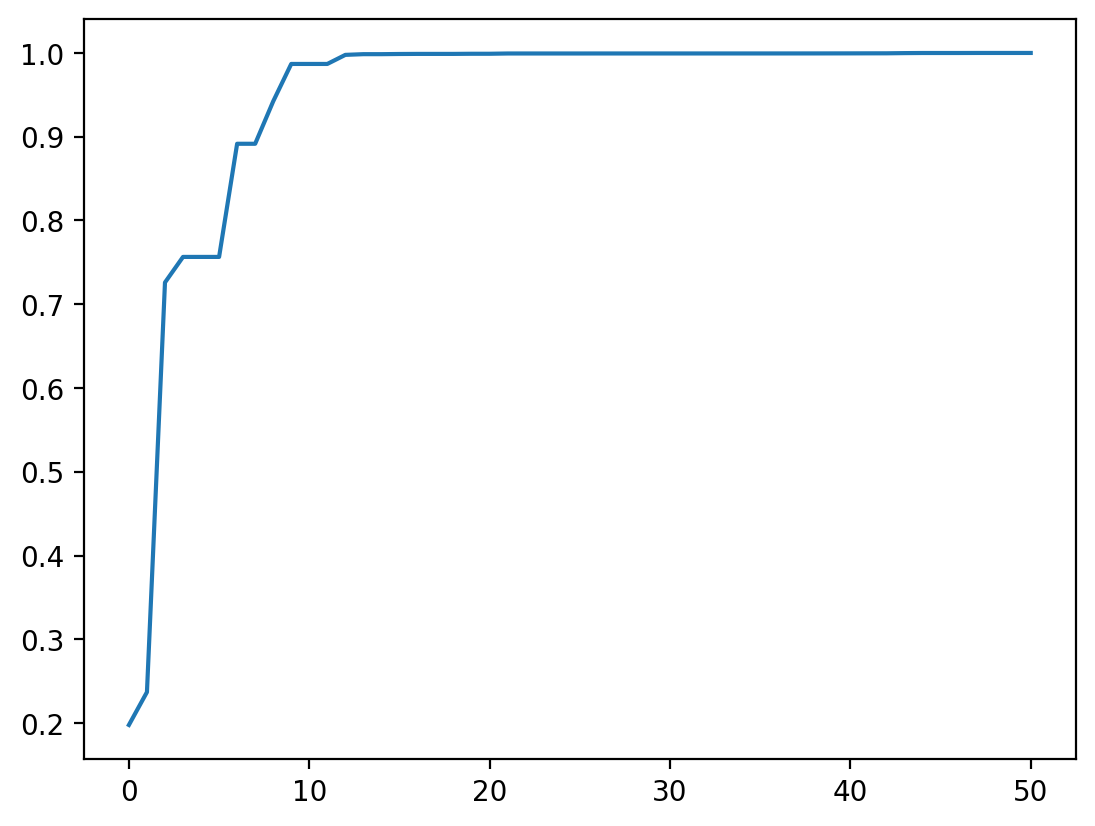

Minimo encontrado con ABC en funcion Ackley: [-2.34346804e-08 -2.34346804e-08], fn=9.373874876317245e-08


In [ ]:
# instancia optimizador ABC para minimizar la funcion ackley

foodsources = ABC_foodsources(5, coord_min, coord_max)
abc_optimizer_ackley = ABC(ackley, foodsources, 25, 50)
best_solution, best_fitness, history_bestfitness, history_bestsolution = abc_optimizer_ackley.optimize()

# muestra la evolucion del mejor fitness
print(history_bestfitness)
plt.plot(history_bestfitness)
plt.show()

ackley_best_solution = ackley(best_solution)
print("Minimo encontrado con ABC en funcion Ackley: {}, fn={}".format(best_solution, ackley_best_solution))

positions = np.array(history_bestsolution)
positions = pd.DataFrame({"x": positions[:,0], "y": positions[:,1]})

figure = px.scatter(positions, x="x", y="y", range_x=[x_min, x_max], range_y=[y_min, y_max], animation_frame=positions.index)
figure.show()

 ## Probando el algoritmo PSO

 los parametros que se pasan a PSO son (fn, PN, Xmin, Xmax, w, phi1, phi2, max_iter):

        fn: La funcion a ser minimizada
        PN: numero de particulas
        Xmin: vector con los limites inferiores para delimitar el espacio de busqueda
        Xmax: vector con los limites superiores para delimitar el espacio de busqueda
        w: factor de inercia de la particula
        phi1: peso de aprendizaje cognitivo
        phi2: peso de aprendizaje social
        max_iter: número total de iteraciones que ejecutará PSO

In [ ]:
# instancia fuentes de comida para ABC
x_min = -20
y_min = -20

x_max = 20
y_max = 20

coord_min = [x_min, y_min]
coord_max = [x_max, y_max]


<b> Optimizacion PSO en la funcion Ackley </b>

Mejor solucion encontrada por PSO: [-0.00118198 -0.00118198], fitness = 0.9952206289234737. Tomo 0.017989635467529297 seg 
[0.09839855832567714, 0.5080748514948162, 0.6271136398275701, 0.2148288625142621, 0.45422456575726516, 0.6566119511720274, 0.21574333509503593, 0.9087126789697949, 0.6014882831121243, 0.7177123393511294, 0.7512134208459276, 0.8283547882950167, 0.28520201208015206, 0.25513511912438475, 0.6649217610904321, 0.743583061480122, 0.7415648488293854, 0.24618519482684617, 0.950117510047792, 0.218598519533887, 0.3912525663850257, 0.22521903004543267, 0.33324675664064934, 0.37745562468216237, 0.6812120240234385, 0.2228071544787206, 0.8362802143897428, 0.7891280122494195, 0.5566542873269767, 0.9317080186305434, 0.24584461129069216, 0.757119417932205, 0.3152312421800418, 0.895575396605878, 0.2185923259110451, 0.4563456794688954, 0.3412652020249786, 0.3727855081923519, 0.4092996337834627, 0.2186015214789426, 0.21615838278292468, 0.9731629119938542, 0.9952206289234737, 0.21860335

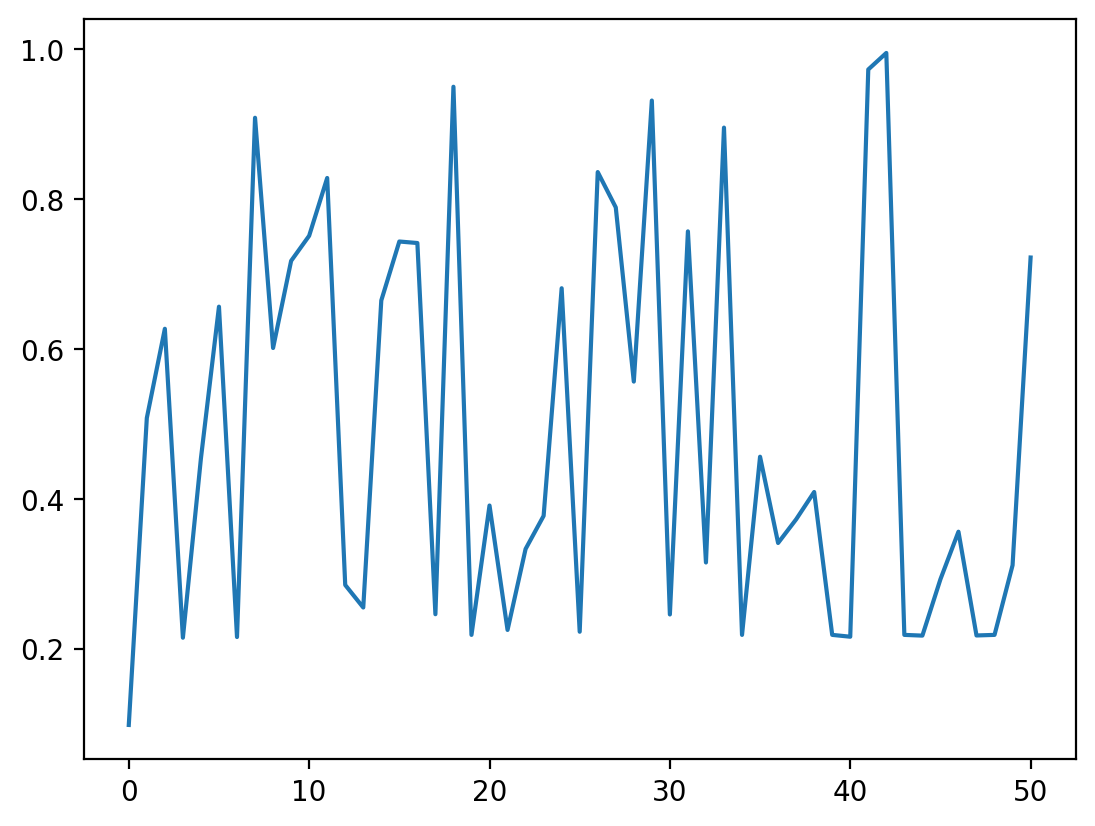

Minimo encontrado con PSO en funcion Ackley: [-0.00118198 -0.00118198], fn=0.004802323160941757


In [ ]:
# instancia optimizador PSO para minimizar la funcion ackley
# Importante: Inicializar particulas por cada ejecucion
particles = PSO_particles(10, coord_min, coord_max)
pso_optimizer_ackley = PSO(ackley, particles, 0.01, 2, 2, 50)
best_solution, best_fitness, history_bestfitness, history_bestsolution = pso_optimizer_ackley.optimize()

# muestra la evolucion del mejor fitness
print(history_bestfitness)
plt.plot(history_bestfitness)
plt.show()

ackley_best_solution = ackley(best_solution)
print("Minimo encontrado con PSO en funcion Ackley: {}, fn={}".format(best_solution, ackley_best_solution))

positions = np.array(history_bestsolution)
positions = pd.DataFrame({"x": positions[:,0], "y": positions[:,1]})

figure = px.scatter(positions, x="x", y="y", range_x=[x_min, x_max], range_y=[y_min, y_max], animation_frame=positions.index)
figure.show()

# Tareas y cuestiones:
Analice el código mostrado previamente y responda las siguientes preguntas.

Considere la siguiente información de apoyo:

-**nparg = np.array(arg)** permite que una copia de **arg** - siendo **arg** un iterador - pueda ser entregada como arreglo numpy a la variable **nparg**.  


-**np.argmax(nparr)** sirve para obtener la posicion en que se encuentra el valor mas alto de **nparr**, **nparr** tiene que ser un arreglo numpy.


-**np.mean(nparr)** sirve para obtener la media de los valores de **nparr**, **nparr** tiene que ser un arreglo numpy.


-**np.std(nparr)** sirve para obtener la desviacion estandar de los valores de **nparr**, **nparr** tiene que ser un arreglo numpy.

**1) Elabore un código que permita ejecutar 10 veces ABC en la función Ackley usando los siguientes parámetros: (2 pts)**

      - SN = 5
      - limit = 25
      - max_iter = 50
      - coord_min = [-20, -20]
      - coord_max = [20, 20]    
      
Registre la media y desviación estandard del fitness de la mejor solución encontrada en cada ejecución.

In [ ]:
x_min = -20
y_min = -20

x_max = 20
y_max = 20

coord_min = [x_min, y_min]
coord_max = [x_max, y_max]

In [ ]:
#COMPLETE SU CODIGO AQUI

**2) A partir del análisis de resultados debería poder inferir el comportamiento en ABC : Detalle la capacidad de ABC de encontrar óptimos con la función de ackley considerando el comportamiento del ABC desde las primeras a las últimas generaciones, para esto considere incluir en su explicacion la influencia de los parametros de limit y trials. Detalle la variabilidad que se tiene en las ejecuciones y si hay alguna relación entre la mejora en el fitness y el número de iteraciones. Inicializando en cada ejecucion las fuentes de comida, existe un comportamiento particular del algoritmo que se conserva ¿cuál es?.  (3 pts)**

RPTA

**3) Elabore un código que permita ejecutar 10 veces PSO en la funcion Ackley usando los siguientes parámetros: (2 pts)**

      - PN = 10
      - w = 0.01
      - phi1 = 2
      - phi2 = 2
      - max_iter = 50
      - coord_min = [-20, -20]
      - coord_max = [20, 20]    
      
Registre la media y desviación estandard del fitness de la mejor solución encontrada en cada ejecución.

In [ ]:
x_min = -20
y_min = -20

x_max = 20
y_max = 20

coord_min = [x_min, y_min]
coord_max = [x_max, y_max]


In [ ]:
#COMPLETE SU CODIGO AQUI

**4) En base a los resultados de las ejecuciones de PSO: Detalle la capacidad de PSO de encontrar óptimos con la función de ackley considerando el comportamiento del PSO desde las primeras a las últimas generaciones y si se tiene algún patrón reconocible conocido. Detalle la variabilidad que se tiene en las ejecuciones y si hay alguna relación entre la mejora en el fitness y el número de iteraciones. Detalle el comportamiento del algoritmo frente a visitas a óptimos locales. (3 pts)**

RPTA

**5) Elabore un código que permita ejecutar PSO en la función Ackley usando los siguientes parámetros, variando el parámetro phi1. (2 pts)**

      - PN = 10
      - max_iter = 50
      - w = 0.01
      - phi1 = {0.1, 2, 10}
      - phi2 = 2
      - coord_min = [-5, -5]
      - coord_max = [5, 5]

Para cada valor de phi1 ejecute al menos 10 repeticiones. Registre la media y desviación estándar.

In [ ]:
x_min = -20
y_min = -20

x_max = 20
y_max = 20

coord_min = [x_min, y_min]
coord_max = [x_max, y_max]


In [ ]:
#COMPLETE SU CODIGO AQUI

**6) Elabore un código que permita ejecutar PSO en la función Ackley usando los siguientes parámetros, variando el parámetro phi2. (2 pts)**
     
      
      - PN = 10
      - max_iter = 50
      - w = 0.01
      - phi1 = 2
      - phi2 = {0.1, 2, 10}
      - coord_min = [-5, -5]
      - coord_max = [5, 5]


Para cada valor de phi2 ejecute al menos 10 repeticiones. Registre la media y desviación estándar.

In [ ]:
x_min = -20
y_min = -20

x_max = 20
y_max = 20

coord_min = [x_min, y_min]
coord_max = [x_max, y_max]

In [ ]:
#COMPLETE SU CODIGO AQUI

**7) Basandose en sus resultados en las preguntas 5 y 6, explique como influye el aprendizaje cognitivo y el aprendizaje social en la búsqueda de óptimos. 1 punto por el análisis de cada una de las seis combinaciones phi1 = [0.1,2,10], phi2 = [0.1,2,10] .
 (6 pts)**

RPTA